Привет, меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ..
</div>
<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

<font color='orange' style='font-size:24px; font-weight:bold'>Полезные ссылки:</font>
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
- Приятное оформление выводов и структурированность кода в целом!  Приятно проверять такие работы.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
- Жду твой обновленный проект =)



<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[3]</font>
* Спасибо за оперативность
- Приятно видеть фидбек 
- Недочеты исправлены - работа полностью корректна
- Рад был быть полезен. Удачи в дальнейшем обучении!


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
import numpy as np
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


In [2]:
try:
    df = pd.read_csv('taxi.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df[df.duplicated()]

,datetime,num_orders


In [6]:
print('минимальная дата', df.datetime.unique()[0])
print('максимальная дата', df.datetime.unique()[-1])

минимальная дата 2018-03-01 00:00:00
максимальная дата 2018-08-31 23:50:00


По результатам обзорного анализа данных: пропусков в данных нет, минимальное количество заказов - 0, максимальное 119, дубликатов нет, данные за период с 1 марта 2018 до 31 августа 2018, за каждые 10 минут.

In [7]:
df.set_index(pd.to_datetime(df.datetime), drop=True, inplace=True)
df.drop(['datetime'], axis=1, inplace=True)

In [8]:
print('Монотонно ли увеличивается индекс?', df.index.is_monotonic_increasing)

Монотонно ли увеличивается индекс? True


In [9]:
df = df.resample('1H').max()

Выше проверка на монотонность и ресемплинг датасета с промежутком в один час. В качестве агрегирующей выбрана функция max поскольку так мы можем быть уверены, что заказов было как минимум столько сколько составляет максимальное значение заказов за период. С учетом того что заказы пересекаются по времени более точно подобрать агрегирующую функцию тяжело.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные осмотрены, ресемпилнг был сделан верно.
</div>


## Анализ

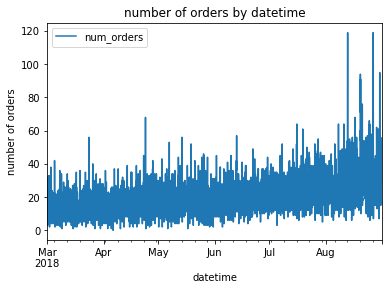

In [10]:
df.plot(title='number of orders by datetime', ylabel='number of orders');

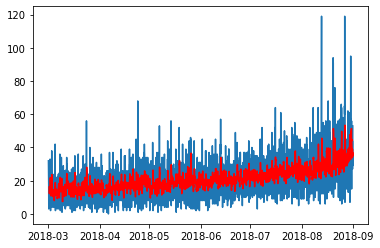

In [11]:
df_rolling_mean = df.rolling(10, closed='left').mean()
fig, ax = plt.subplots(1, 1)
ax.plot(df)
ax.plot(df_rolling_mean, color='red');


<div class="alert alert-block alert-danger">

<b>Ошибка:</b>
При использовании `.rolling()` в такой постановке скользящее среднее считается с учётом текущего шага - это не совсем верно для задачи временных рядов, так как будет работать только для известных нам значений и сломается на предсказаниях.
        
Нужно либо использовать `.shift()` перед `.rolling()`, либо параметру `closed` при использовании `.rolling()` передать значение `left`.
    
Ниже - наглядная визуализация:
    
[![2023-07-11-15-48-51.png](https://i.postimg.cc/cH9tDwq4/2023-07-11-15-48-51.png)](https://postimg.cc/BLFvb8Qd)
    
Тут и далее по проекту.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Внёс соответствующие изменения в код, но мне осталось непонятным почему нам нужно использовать closed = 'left' или .shift(), для чего нам надо исключить самую правую конечную точку при расчёте скользящей средней? Это если я правильно понял как работает closed = 'left' или .shift(), конечно.
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b>  Когда мы будем делать предсказание на новых данных, у нас будет неизвестный целевой признак (num_orders) для текущего шага, а только за предыдущие шаги - поэтому и здесь коректнее считать скользящее среднее без текущего шага.
</div>


После расчёта скользящей средней лучше прослеживается тренд, средняя увеличивается к концу наблюдаемого периода.

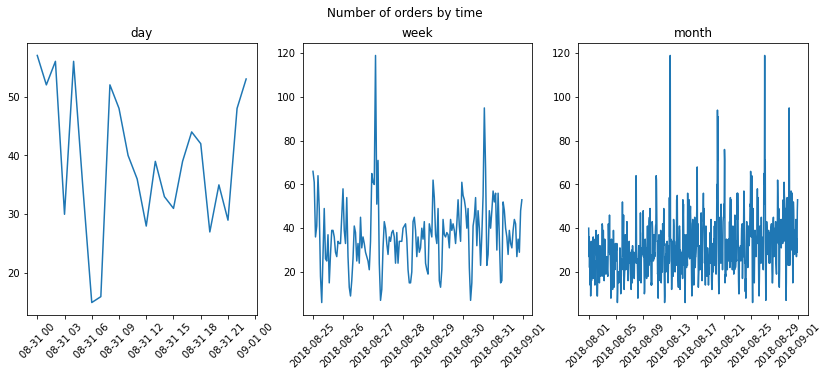

In [12]:
day = df[df.index > (df.index.max() - pd.DateOffset(days=1))]
week = df[df.index > (df.index.max() - pd.DateOffset(weeks=1))]
month = df[df.index > (df.index.max() - pd.DateOffset(months=1))]
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].plot(day)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
ax[0].set_title('day')
ax[1].plot(week)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
ax[1].set_title('week')
ax[2].plot(month)
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=45)
ax[2].set_title('month')
plt.suptitle('Number of orders by time');

Из графика для 1 дня видно, что в течение дня бывают довольно сильные просадки. Посмотрим каким днём недели был пик на недельном графике... И им оказался понедельник, что ничего особо нам не говорит. Можно конечно начать спекулировать, но не вижу в этом смысла.

In [13]:
decomposed = seasonal_decompose(df)

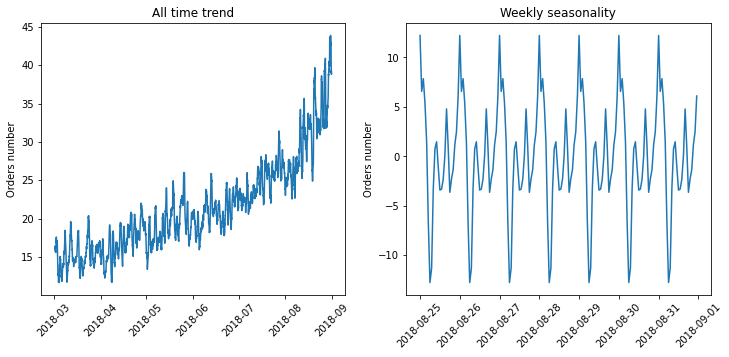

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(decomposed.trend)
ax[0].set_title('All time trend')
ax[0].set_ylabel('Orders number')
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45);
ax[1].plot(decomposed.seasonal[df.index > (df.index.max() - pd.DateOffset(weeks=1))])
ax[1].set_title('Weekly seasonality')
ax[1].set_ylabel('Orders number')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45);

При помощи функции seasonal_decompose из statsmodels.tsa.seasonal можно разложить временной ряд на тренд, сезонность и остаток. На графике тренда видно, что среднее количество заказов увеличивается к концу наблюдаемого периода. На графике сезонности недели видно, что в течение дня количество заказов увеличивается к вечеру, график цикличный. На графиках для дня и месяца ничего интересного, сезонности не прослеживается.

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана тоже правильно. Радует, что сезонность была визуализирована на более коротком интервале и заметил. С наблюдениями согласен
</div>


In [15]:
from statsmodels.tsa.stattools import adfuller

alpha0 = 0.05
alpha1 = 0.01
result = adfuller(df['num_orders'])

print('Test statistic:', result[0])
print('P-value:', pvalue := result[1])

if pvalue < alpha0:
    print('The series is likely stationary for 5% significance level')
else:
    print('The series is likely non-stationary for 5% significance level')

if pvalue < alpha1:
    print('The series is likely stationary for 1% significance level')
else:
    print('The series is likely non-stationary for 1% significance level')

Test statistic: -3.0555971185204864
P-value: 0.030018526353333217
The series is likely stationary for 5% significance level
The series is likely non-stationary for 1% significance level


Исходя из теста Дики-Фуллера можно сделать вывод, что ряд стационарный, если ориентироваться на мягкий критерий 0.05.



<div class="alert alert-block alert-info">
    
<b>Совет:</b> Дополнительно  неплохо было бы исследловать стационарность ряда. 
    
Это можно оценивать с помощью графика или же теста Дики-Фуллера: в реальных задачах с временными рядами, в особенности - с финансовыми данными или биржевыми котировками, график не всегда поможет достоверно оценить стационарность ряда, поэтому для оценки стационарности ряда лучше использовать тест Дики — Фуллера (подробнее о нём можно глянуть тут: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html, а вот тут можно глянуть пример реализации: https://www.helenkapatsa.ru/tiest-diki-fulliera/) - он даст наиболее точный результат. Результат нужно проверить на уровнях значимости 1% и 5%, чтобы быть уверенным в выводах. Не забудь при применении теста сформулировать гипотезы - нулевая формулируется как гипотеза о нестацинарности ряда, а альтернативная - как гипотеза о стационарности ряда. Также при проведении теста не забывай, что мы сравниваем `p-value` с уровнем значимости `alpha`.
</div>


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил проверку на Дики-Фуллера
</div>



<div class="alert alert-block alert-info">
    
<b>Совет[2]:</b>
    
В строгом смысле наш ряд не является стационарным, потому что имеет не только тренд, но еще и с августа - ускорение (квадратичный тренд). Дисперсия также непостоянна.
    
Однако есть методы, с помощью которых можно попытаться привести ряд к стационарному. Например, если возьмем разность временного ряда, то уберем тренд. Если применим преодразование Бокса-Кокса, то уберем неоднородность дисперсии. Можно взять разность по сезонности и уберем сезонность.
    
Наши модели могут предсказывать ряд без всех этих преобразований. Делать преобразования нам не нужно. Можно просто протестировать, приводим ли наш ряд к стационарному. Часто в задачах ML ряд, приводимый к стационарному для простоты называют стационарным. Однако строго по определению он таковым не является.



## Обучение

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

df = make_features(df, 10, 10)


<div class="alert alert-block alert-danger">
<b>Ошибка[2]:</b> Не все выбранные признаки нам подходят:
    
месяц:   У нас данных меньше года, в истории всего один март, май.... Да и горизонт прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.
    
день:  также не подходит, будет просто последовательность чисел<br>
</div>		
    

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Убрал день и месяц.
</div>

<div class="alert alert-block alert-success">
<b>Успех[3]:</b> Есть контакт
</div>




<div class="alert alert-info">
<b>Совет[2]:</b>
Организация работы функции таким образом, чтобы она работала с глобальной переменной - не самая хорошая практика: если что-то пойдёт не так, придётся заново запускать весь процесс предобработки данных. 
        
Лучше организовывать функцию так, чтобы она принимала на вход набор данных и возвращала результат работы, чтобы его можно было сохранить в новой переменной. Концепт:
        
    def foo(df):
        df.dropna(inplace=True)
    
    foo(df)
        
В этом случае изменения необратимы, так как мы модифицировали глобальную переменную `df` - эту переменную придётся загружать в память заново и заново её обрабатывать.
        

    def foo(df):
        return df.dropna()
    
    foo(df)
        
        
Изменения будут необратимы и в таком случае, даже несмотря на на наличие `return`: несмотря на то, что работаем мы с локальной переменной, функция всё равно работает с объектом в памяти, связанным с глобальной переменной, пусть и через алиас.
        
    def foo(df):
        df_foo = df.copy()
        return df_foo.dropna()
    
    df_new = foo(df)
        
Здесь внутри функции исходный объект копируется, и работа уже происходит с новым объектом. В этом случае результат работы функции с исходными данными мы складываем в новую переменную - таким образом исходная глобальная переменная не подвергается вмешательству и сохранятся на случай, если функция сработала неправильно.
        
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Учту, спасибо.
</div>

In [17]:
df.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,32,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,25,1,3,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,22,2,3,25.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,20,3,3,22.0,25.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,17,4,3,20.0,22.0,25.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<div class="alert alert-block alert-danger">

<b>Ошибка:</b> Прежде чем переходить к разбиению данных - нужно создать признаки для обучения модели (вы делали такое в тренажере, загляни туда, если забыл).
    
То есть нужно определить функции `make_features`, которой на вход приходит наш датафрейм и нужно сгенерировать полезные для модели фичи. С помощью  индекса (даты) создать новые колонки (часы, день,  день недели, месяц, год), но нам нужны не все, а только важные - подумай над этим. Также нужно использовать lag и скользящее среднее. 

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил функцию make_features.
</div>

In [18]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=999)


<div class="alert alert-block alert-danger">

<b>Ошибка:</b> Согласно ТЗ, рамзер тестовой выборки должен быть 10%.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Исправил, X_valid нам не понадобится так как возьмем X_train и зафиксируем там валидационную выборку при помощи PredefinedSplit.
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b>  Есть
</div>


In [61]:
models = {
    'LGBMRegressor': LGBMRegressor(verbose=-1),
    'CatBoostRegressor': CatBoostRegressor(verbose=False)
}

param_grids = {
    'LGBMRegressor': {
        'num_leaves': [7, 14, 21],
        'learning_rate': [0.1, 0.03],
        'max_depth': [-1, 3, 5],
        'n_estimators': [50, 100, 150],
    },
    'CatBoostRegressor': {
        'iterations': [50, 100, 150],
        'depth': [4, 6, 8],
        'learning_rate': [0.1, 0.03],
        'l2_leaf_reg': [1, 3, 5],
    }
}

# Фиксируем значения валидационной выборки при помощи PredefinedSplit. Таким образом 
# мы можем использовать GridSearchCV без кросс-валидации.
split_index = np.zeros(X_train.shape[0])
split_index[:int(X_train.shape[0] * 0.7888)] = -1
ps = PredefinedSplit(split_index)

best_params = dict()
for model_name in models.keys():
    model = models[model_name]
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=ps,
        scoring='neg_mean_squared_error',
        return_train_score=False,
    )

    grid_search.fit(X_train, y_train)
    preds = grid_search.predict(X_test)
    
    best_params[model_name] = grid_search.best_params_

    print(f'Best params for {model_name}: {grid_search.best_params_}')
    print(f'Best score for {model_name} with best parameters: {grid_search.best_score_}')

Best params for LGBMRegressor: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 150, 'num_leaves': 14}
Best score for LGBMRegressor with best parameters: -70.09501253034922
Best params for CatBoostRegressor: {'depth': 6, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best score for CatBoostRegressor with best parameters: -69.87299640034055



<div class="alert alert-block alert-danger">

<b>Ошибка:</b> Ты используешь кросс-валидацию - в случае с временным рядом нужно задать кросс-валидацию TimeSeriesSplit (иначе мы будем заглядывать в будущее).
    


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Функция для подбора гиперпараметров осталась той же - GridSearchCV. Это второе разделение данных, первым шагом я вытащил тестовую выборку, потом фиксированным сплитом я создал валидационную и тренировочную выборки, валидационная выборка составила примерно 20% от оригинальной. Благодаря тому что фиксированные значения для тренировочной и валидационной выборок передаются в функцию GridSearch то кросс валидация не происходит.
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Принял, спасибо за разъяснение, не популярное решение, но вполне имеет место быть.
</div>



<div class="alert alert-block alert-info">
<b>Совет:</b> Не совсем понимаю, зачем нужна кросс-валидаци если при разбиении ты разделил данные на 3 выборки

</div>


Лучшим показал себя CatBoost, со счетом -69.87.


<div class="alert alert-block alert-danger">

<b>Ошибка[2]:</b> Вместо предсказания на тестовой выборке, лучше использовать `.best_score`.  Тестовая выборка это имитация данных, которые нам будут приходить в будущем, и мы проводим оценивае на такой выборке, чтобы посмотреть, как модель будет работать на данных, под которые мы модель не подгоняли.  Данное оценивание принято делать только для одной лучшей модели, после того как мы ее выбираем для тестирования

    


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Поменял RMSE на best_score.
</div>

<div class="alert alert-block alert-info">
<b>Совет[3]:</b> Тогда и от этого можно избавиться preds = grid_search.predict(X_test)

## Тестирование

In [66]:
print('Лучшие параметры для CatBoost', best_params.get('CatBoostRegressor'))
model = CatBoostRegressor(**best_params.get('CatBoostRegressor'), verbose=False)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE for LGBMRegressor with best parameters: {rmse}')

Лучшие параметры для CatBoost {'depth': 6, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

RMSE for LGBMRegressor with best parameters: 11.303460236904172


<div class="alert alert-block alert-success">
<b>Успех[3]:</b> На тестовой получено хорошее качество
</div>



<div class="alert alert-block alert-info">
<b>Совет:</b>  Не путай пожалуйста смысловые значение тестовой и валидационной выборки. Тестирование проводят на тестовой, а не валидационной.
</div>


Результаты получились даже лучше чем на тестовой выборке.
__Вывод__: В результате работы был проведён исследовательский анализ данных а также создана модель которая подходит под требования заказчика. Модель более чем в 4 раза ниже верхней границы ошибки установленной заказчиком.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48